In [17]:
from plotly.express import scatter_geo
import pandas as pd
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [18]:
from google.colab import drive
drive.mount('/content/drive')
df1 = pd.read_csv("/content/drive/MyDrive/internship_and_resume_work/202210-baywheels-tripdata.csv")
df2 = pd.read_csv("/content/drive/MyDrive/internship_and_resume_work/202210-baywheels-tripdata.csv")
df = pd.concat([df1, df2])

df = df1



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Plots every starting point onto map with bounds specified by where the locations are (SF, SJ, Berk, Oak)
#scatter_geo(df, lat = "start_lat", lon = "start_lng", scope = "usa", fitbounds = "locations")

In [19]:

#Creates two more columns, the start and end cities which exclude station ID and only specify city
df["start_city"] = df.start_station_id.str[0:2]
df["end_city"] = df.end_station_id.str[0:2]


In [20]:
# All of the rides that ended in different city than started in
df[df.start_city != df.end_city].dropna()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_city,end_city
12,B3C1CC82A8F4B6C8,classic_bike,2022-10-15 17:08:02,2022-10-15 17:14:04,Genoa St at 55th St,OK-D2,Adeline St at 40th St,EM-D4,37.839649,-122.271756,37.831277,-122.278267,member,OK,EM
21,0C3542492CF5BC58,classic_bike,2022-10-15 11:58:31,2022-10-15 12:12:04,San Pablo Park,BK-G4,Emeryville Public Market,EM-B1,37.855783,-122.283127,37.840521,-122.293528,casual,BK,EM
66,FE5266AB5587D15B,classic_bike,2022-10-19 17:10:41,2022-10-19 17:20:29,College Ave at Taft Ave,OK-B5,Derby St at College Ave,BK-F10,37.841800,-122.251535,37.861804,-122.253569,member,OK,BK
67,EC181C18A5DFDC19,classic_bike,2022-10-03 16:57:17,2022-10-03 17:05:34,College Ave at Taft Ave,OK-B5,Derby St at College Ave,BK-F10,37.841800,-122.251535,37.861804,-122.253569,member,OK,BK
74,79A4A1FF805D6A90,classic_bike,2022-10-07 01:02:06,2022-10-07 01:17:21,55th St at Telegraph Ave,OK-C3,Derby St at College Ave,BK-F10,37.840186,-122.261822,37.861804,-122.253569,casual,OK,BK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264653,665F4707905EDFDC,electric_bike,2022-10-02 15:19:03,2022-10-02 15:47:36,Hardly Strictly Bluegrass,SpecialEventTempStation,Dolores St at 15th St,SF-M21,37.770796,-122.478974,37.766100,-122.426659,casual,Sp,SF
264976,91B3E308236B6391,classic_bike,2022-10-19 16:05:26,2022-10-19 16:27:35,Hearst Ave at Euclid Ave,BK-C9,Stanford Ave at Hollis St,EM-B2,37.875321,-122.260155,37.838443,-122.288665,member,BK,EM
264977,6FC7C977F7B896E2,classic_bike,2022-10-31 17:38:43,2022-10-31 17:59:51,Hearst Ave at Euclid Ave,BK-C9,Stanford Ave at Hollis St,EM-B2,37.875321,-122.260155,37.838443,-122.288665,member,BK,EM
264978,4AC4FAC551062B53,classic_bike,2022-10-21 17:11:56,2022-10-21 17:35:49,Hearst Ave at Euclid Ave,BK-C9,Stanford Ave at Hollis St,EM-B2,37.875321,-122.260155,37.838443,-122.288665,member,BK,EM


In [21]:
# How many rides started in each city
df.groupby("start_city").count()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,end_city
start_city,,,,,,,,,,,,,,
40,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BK,6165,6165,6165,6165,6165,6165,6152,6152,6165,6165,6152,6152,6165,6152
EM,793,793,793,793,793,793,790,790,793,793,790,790,793,790
OK,9322,9322,9322,9322,9322,9322,9297,9297,9322,9322,9297,9297,9322,9297
SF,202129,202129,202129,202129,202129,202129,175426,174753,202129,202129,201968,201968,202129,174753
SJ,5541,5541,5541,5541,5541,5541,5016,5016,5541,5541,5514,5514,5541,5016
Sp,843,843,843,843,843,843,753,751,843,843,843,843,843,751


In [22]:
# Create new data frame with only the SF starting point
sf = df[df.start_city == "SF"].dropna()
# Remove rides which do not end in SF
sf = sf.drop(sf[sf["end_city"] != "SF"].index)
# Remove rides which begin and end in the same station (either only unlocked bike for a few seconds or just rode in a loop back to station)
sf = sf.drop(sf[sf.start_station_name == sf.end_station_name].index)




In [23]:
# Ensures every ride start and end in a different station, should count zero
sf[sf.start_station_name == sf.end_station_name].count()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
start_city            0
end_city              0
dtype: int64

In [24]:
# See how many rides had unique pairing of start and end coords
sf.groupby(["start_lat", "start_lng"]).count().sort_values("ride_id", ascending=False).query("ride_id == 1").sum()

ride_id               97095
rideable_type         97095
started_at            97095
ended_at              97095
start_station_name    97095
start_station_id      97095
end_station_name      97095
end_station_id        97095
end_lat               97095
end_lng               97095
member_casual         97095
start_city            97095
end_city              97095
dtype: int64

In [25]:
# See stations with most amount of rides started at, #1 has ~2500
sf.groupby("start_station_id").count().sort_values("start_station_name", ascending = False)

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_city,end_city
start_station_id,,,,,,,,,,,,,,
SF-J23-1,2536,2536,2536,2536,2536,2536,2536,2536,2536,2536,2536,2536,2536,2536
SF-E29-2,2417,2417,2417,2417,2417,2417,2417,2417,2417,2417,2417,2417,2417,2417
SF-G27,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138
SF-J29,1985,1985,1985,1985,1985,1985,1985,1985,1985,1985,1985,1985,1985,1985
SF-H26,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SF-Z28,12,12,12,12,12,12,12,12,12,12,12,12,12,12
SF-Y25,12,12,12,12,12,12,12,12,12,12,12,12,12,12
SF-AA28,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [26]:
# Find the mean latitude and longitude of each station
sf.groupby(["start_station_id", "start_station_name"]).mean()


,,start_lat,start_lng,end_lat,end_lng
start_station_id,start_station_name,,,,
SF I29-1,Bryant St at 2nd St,37.783251,-122.393357,37.781686,-122.403861
SF-A15,Mason St at Halleck St,37.803964,-122.455092,37.797805,-122.427482
SF-A19,Fillmore St at Jefferson St,37.805334,-122.437244,37.793996,-122.418442
SF-A20,Buchanan St at North Point St,37.804431,-122.433531,37.793089,-122.422314
SF-A22,North Point St at Polk St,37.805419,-122.423055,37.792235,-122.415236
...,...,...,...,...,...
SF-Z13,Brighton Ave at Ocean Ave,37.723433,-122.455109,37.737306,-122.446393
SF-Z16,Delano Ave at Oneida Ave,37.722406,-122.443791,37.751886,-122.420043
SF-Z28,Carroll Ave at 3rd St,37.725371,-122.393955,37.760779,-122.409219


In [27]:
# Create data frames containing each station and their average lat/lng coordinates as start and ends 
# NOTE: identical stations will have slightly different coords as start versus end station
start_station_means = sf.groupby("start_station_id").mean()
end_station_means = sf.groupby("end_station_id").mean()

In [28]:
# Replace exact coordinates with the average start and end coordinates of the station
sf_with_mean_locations = pd.merge(sf.drop(["start_lat", "start_lng"], axis=1), start_station_means, on = "start_station_id")
sf_with_mean_locations = pd.merge(sf_with_mean_locations.drop(["end_lat_x", "end_lng_x", "end_lat_y", "end_lng_y"], axis=1), end_station_means[["end_lat", "end_lng"]], on = "end_station_id")


In [29]:
# Create two columns, one containing the frequency of the start station, one for frequency of end station (NOTE frequencies will be different as start vs end for identical stations)
start_station_frequencies = sf_with_mean_locations.groupby("start_station_id").count()
start_station_frequencies = start_station_frequencies["ride_id"]
end_station_frequencies = sf_with_mean_locations.groupby("end_station_id").count()
end_station_frequencies = end_station_frequencies["ride_id"]

In [30]:
# Adds column into sf data frame with frequency of the start station
sf_with_mean_locations = pd.merge(sf_with_mean_locations, start_station_frequencies, on = "start_station_id")
sf_with_mean_locations.sort_values("start_station_id")
sf_with_mean_locations = sf_with_mean_locations.rename(columns = {"ride_id_x" : "ride_id", "ride_id_y" : "start_station_frequency"})

In [31]:
# Adds column into sf data frame with frequency of the end station
sf_with_mean_locations = pd.merge(sf_with_mean_locations, end_station_frequencies, on = "end_station_id")
sf_with_mean_locations.sort_values("end_station_id")
sf_with_mean_locations = sf_with_mean_locations.rename(columns = {"ride_id_x" : "ride_id", "ride_id_y" : "end_station_frequency"})

In [ ]:
# Plot starting points by station, larger circles mean higher frequency of departure point
scatter_geo(sf_with_mean_locations.sample(frac = 0.1), lat = "start_lat", lon = "start_lng", scope = "usa", fitbounds = "locations", size = "start_station_frequency")

In [ ]:
# Plot ending points by station, larger circles mean higher frequency of ending point
scatter_geo(sf_with_mean_locations.sample(frac = 0.1), lat = "end_lat", lon = "end_lng", scope = "usa", fitbounds = "locations", size = "end_station_frequency")

In [39]:
# Takes as input two series of timestamps of the same length
# Return a list of the same length as the input lists containing the different in seconds between corresponding timestamps in input lists
def ride_times_series(starts, ends):
  ride_times = []
  for i in range(len(starts)):
    ride_times.append(datetime.strptime(ends[i][2:], "%y-%m-%d %H:%M:%S").timestamp() - datetime.strptime(starts[i][2:], "%y-%m-%d %H:%M:%S").timestamp())
  return ride_times

In [40]:
# Adds column into dataframe containing the ride time in seconds
sf_with_mean_locations["ride_time"] = ride_times_series(sf_with_mean_locations.started_at, sf_with_mean_locations.ended_at)

In [41]:
# Takes as input floats representing two sets of coordinates
# Returns float representing haversine distance between the two, or the angular distance between two points on the surface of a sphere
# 3956 represents the radius of the Earth
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles
    return c * r

In [42]:
# Takes as input four series corresponding to starting and ending coordinates for all rides, all series are identical length
# Return a list of the same length as the input lists containing the haversine distance between start and end coordinates in corresponding input lists
def haversine_series(start_lngs, start_lats, end_lngs, end_lats):
  distance_series = []
  for i in range(len(start_lngs)):
    distance_series.append(haversine(start_lngs[i], start_lats[i], end_lngs[i], end_lats[i]))
  return distance_series

In [43]:
# Adds column into data frame containing distance between start and end stations
sf_with_mean_locations["haversine_distance"] = haversine_series(sf_with_mean_locations.start_lng, sf_with_mean_locations.start_lat, sf_with_mean_locations.end_lng, sf_with_mean_locations.end_lat)

In [44]:
# Takes as input series containing whether each bikes user was electric or classic
# Returns list containing a 1 if a bike was electric, and 0 if the bike was a classic
def bike_types(bikes):
  bike_types = []
  for i in range(len(bikes)):
    if (bikes[i] == "electric_bike"):
      bike_types.append(1)
    else:
      bike_types.append(0)
  return bike_types


In [45]:
# Add a column into dataframe using ones and zeroes to representing bike type used for the ride
sf_with_mean_locations["bike_type"] = bike_types(sf_with_mean_locations.rideable_type)

In [46]:
# Takes as input series containing whether each rider was a member or casual user
# Returns list containing a 1 if a user was a member, and 0 if the user was a casual user
def user_types(types):
  user_types = []
  for i in range(len(types)):
    if (types[i] == "member"):
      user_types.append(1)
    else:
      user_types.append(0)
  return user_types

In [47]:
# Add a column into dataframe using ones and zeroes to representing user type for the ride
sf_with_mean_locations["user_type"] = user_types(sf_with_mean_locations.member_casual)

In [48]:
def make_graph(x, y, x_name, y_name, graph_name):
  # plotting the points 
  plt.scatter(x, y, marker = ".", s = 0.5)
  # naming the x axis
  plt.xlabel(x_name)
  # naming the y axis
  plt.ylabel(y_name)
  # giving a title to my graph
  plt.title(graph_name)
  # function to show the plot
  plt.show()

In [49]:
sf_with_mean_locations.sort_values("haversine_distance")

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,start_city,...,start_lat,start_lng,end_lat,end_lng,start_station_frequency,end_station_frequency,ride_time,haversine_distance,bike_type,user_type
128143,E0BDC0BA2DED911E,electric_bike,2022-10-11 13:19:32,2022-10-11 13:30:18,16th St Mission BART,SF-N22-1A,16th St Mission BART Station 2,SF-N22-1B,member,SF,...,37.764703,-122.419924,37.764839,-122.420141,206,651,646.0,0.015118,1,1
128142,22D723A0ABBB0A01,electric_bike,2022-10-08 15:43:20,2022-10-08 15:44:49,16th St Mission BART,SF-N22-1A,16th St Mission BART Station 2,SF-N22-1B,member,SF,...,37.764703,-122.419924,37.764839,-122.420141,206,651,89.0,0.015118,1,1
125123,7E3BC35BFAE79F7F,electric_bike,2022-10-18 09:04:39,2022-10-18 09:44:17,16th St Mission BART Station 2,SF-N22-1B,16th St Mission BART,SF-N22-1A,member,SF,...,37.764854,-122.420124,37.764685,-122.419927,529,227,2378.0,0.015913,1,1
125124,B3BD30B1AF3AB6B6,electric_bike,2022-10-01 15:06:56,2022-10-01 15:19:09,16th St Mission BART Station 2,SF-N22-1B,16th St Mission BART,SF-N22-1A,member,SF,...,37.764854,-122.420124,37.764685,-122.419927,529,227,733.0,0.015913,1,1
125125,D5DA2AECE15B46A3,classic_bike,2022-10-27 23:42:21,2022-10-27 23:55:27,16th St Mission BART Station 2,SF-N22-1B,16th St Mission BART,SF-N22-1A,member,SF,...,37.764854,-122.420124,37.764685,-122.419927,529,227,786.0,0.015913,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111982,65D99B43110AF079,electric_bike,2022-10-12 17:54:21,2022-10-12 18:25:32,Great Hwy at Balboa St,SF-H0,Spear St at Folsom St,SF-F30-2,member,SF,...,37.775294,-122.511212,37.789630,-122.390335,205,784,1871.0,6.670015,1,1
86024,AC3368DE02EA80BE,electric_bike,2022-10-18 15:03:12,2022-10-18 16:06:19,48th Ave at Cabrillo St,SF-J1,Terry Francois Blvd at Warriors Way,SF-M30-2,casual,SF,...,37.772931,-122.509059,37.769095,-122.386333,290,589,3787.0,6.703354,1,0
156446,F29EB666974B77C9,electric_bike,2022-10-21 22:03:07,2022-10-21 23:04:12,Terry Francois Blvd at Warriors Way,SF-M30-2,48th Ave at Cabrillo St,SF-J1,member,SF,...,37.769202,-122.386300,37.772954,-122.509071,583,431,3665.0,6.705579,1,1
159687,0387BC5C01E9AF4F,electric_bike,2022-10-12 14:35:22,2022-10-12 15:41:48,Illinois St at 20th St,SF-O30-2,Great Hwy at Balboa St,SF-H0,casual,SF,...,37.760351,-122.387463,37.775211,-122.511208,741,341,3986.0,6.831500,1,0


In [50]:
sf_with_mean_locations["avg_mile"] = sf_with_mean_locations.ride_time / sf_with_mean_locations.haversine_distance

In [51]:
sf_with_mean_locations = sf_with_mean_locations.drop(sf_with_mean_locations[sf_with_mean_locations.ride_time > 10000].index)


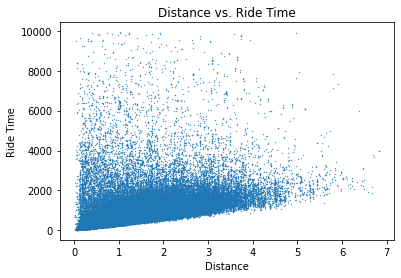

In [52]:
make_graph(sf_with_mean_locations.haversine_distance, sf_with_mean_locations.ride_time, "Distance", "Ride Time", "Distance vs. Ride Time")

In [53]:
# Keep only data with average seconds/mile within two standard deviations of the mean
#Remove largest outliers
sf_with_mean_locations = sf_with_mean_locations.drop(sf_with_mean_locations[sf_with_mean_locations.ride_time > 2000].index)
mean_mile_rate = sf_with_mean_locations.avg_mile.mean()
std_mile_rate = sf_with_mean_locations.avg_mile.std()
print(mean_mile_rate, std_mile_rate)
sf_with_mean_locations = sf_with_mean_locations.drop(sf_with_mean_locations[sf_with_mean_locations.avg_mile < (mean_mile_rate - 2 * std_mile_rate)].index)
sf_with_mean_locations = sf_with_mean_locations.drop(sf_with_mean_locations[sf_with_mean_locations.avg_mile > (mean_mile_rate + 2 * std_mile_rate)].index)


608.0573298327442 591.01996598603


In [54]:
INPUTS = sf_with_mean_locations[["user_type", "bike_type", "haversine_distance", "start_station_name", "end_station_name"]].copy()
one_hot_encoded_input = pd.get_dummies(INPUTS, columns = ["start_station_name", "end_station_name"])
one_hot_encoded_input


,user_type,bike_type,haversine_distance,start_station_name_10th Ave at Irving St,start_station_name_11th St at Bryant St,start_station_name_11th St at Natoma St,start_station_name_14th Ave at Geary Blvd,start_station_name_14th St at Mission St,start_station_name_15th St at Potrero Ave,start_station_name_16th St Mission BART,...,end_station_name_Waller St at Stanyan St,end_station_name_Washington St at Kearny St,end_station_name_Washington St at Van Ness Ave,end_station_name_Webster St at Clay St,end_station_name_Webster St at Grove St,end_station_name_Webster St at O'Farrell St,end_station_name_Webster St at Union St,end_station_name_Williams Ave at 3rd St,end_station_name_Williams Ave at Apollo St,end_station_name_Yerba Buena Center for the Arts (Howard St at 3rd St)
0,1,1,0.759496,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0.759496,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.759496,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1.708112,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1.708112,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165386,1,0,2.577875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165387,1,1,0.953805,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165388,1,1,0.953805,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165389,0,0,0.562898,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
outputs = sf_with_mean_locations["ride_time"]
outputs

0          445.0
1          394.0
2          725.0
3          952.0
4         1430.0
           ...  
165386    1904.0
165387     518.0
165388     763.0
165389     653.0
165390    1732.0
Name: ride_time, Length: 155152, dtype: float64

In [56]:
ride_time_model = LinearRegression().fit(one_hot_encoded_input, outputs)

In [57]:
# Results of the model: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = ride_time_model.score(one_hot_encoded_input, outputs)
print('Coefficient of Determination:', r_sq)

# Print the Intercept:
print('intercept:', ride_time_model.intercept_)

# Print the Slope:
print('slope:', ride_time_model.coef_)

Coefficient of Determination: 0.7144931901646129
intercept: 268.993173760169
slope: [-1.09235371e+02 -1.54390699e+02  4.36227891e+02 -5.53596989e+01
  2.74466679e+01 -3.30238350e-01 -6.02806589e+01 -8.20561213e+00
  3.12026247e+01  2.40832877e+01  2.12631399e+01 -1.61284465e+01
  1.66906229e+01 -6.60202061e+01  2.06131341e+00 -1.11576760e+01
  9.15460599e+00 -9.86504237e+00  3.20612025e+01  1.31418156e+01
  4.48951988e+01  3.44490382e+01 -2.37171808e+01 -4.60659261e+01
  3.45204518e+01 -5.15047695e+00  2.43382508e+01 -6.77406565e+01
 -5.27565704e-01 -1.45409976e+01 -1.61674905e+01  8.49720746e+01
 -1.74495469e+02 -4.81374873e+01 -8.24170311e+01  4.55160351e+01
  3.44162727e+01 -1.77619461e+02 -1.98430730e+02  4.70424749e+01
 -9.28945781e+01  8.76167241e+00  2.92241815e+01  4.45286476e+01
  3.72771724e+01  5.29803728e+01 -4.22093151e+01 -2.68098477e+01
 -1.58765443e+01 -6.68125110e+01 -8.66714153e+01  2.36553182e+01
  4.03552324e+01  5.51321833e+01  4.49352268e+01 -3.58377255e+01
  5.14

In [58]:
sf_with_mean_locations["predictions"] = ride_time_model.predict(one_hot_encoded_input)

In [59]:
sf_with_mean_locations["prediction_diff"] = abs(sf_with_mean_locations.ride_time - sf_with_mean_locations.predictions)

In [60]:
sf_with_mean_locations.sort_values("prediction_diff")


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,start_city,...,end_lng,start_station_frequency,end_station_frequency,ride_time,haversine_distance,bike_type,user_type,avg_mile,predictions,prediction_diff
99819,38FEC72ADF31594E,electric_bike,2022-10-29 20:52:55,2022-10-29 21:03:45,Polk St at Post St,SF-F23,Broadway at Kearny St,SF-C26-1,casual,SF,...,-122.405950,1209,698,650.0,1.079515,1,0,602.122176,650.001080,0.001080
95328,D91EF1DC7AE42845,electric_bike,2022-10-14 12:39:16,2022-10-14 12:45:56,24th St at Bartlett St,SF-Q23-3,Jersey St at Castro St,SF-R19,member,SF,...,-122.433950,682,417,400.0,0.771028,1,1,518.787924,400.001291,0.001291
75784,089909E5047C36B7,electric_bike,2022-10-26 10:34:19,2022-10-26 10:37:12,Folsom St at 3rd St,SF-H28,Bryant St at 2nd St,SF I29-1,member,SF,...,-122.393378,996,463,173.0,0.299821,1,1,577.010330,173.001495,0.001495
54835,5E01D6C3EA6DFD34,classic_bike,2022-10-11 18:48:07,2022-10-11 18:55:45,Mechanics Monument Plaza (Market St at Bush St),SF-F28-1,4th St at Harrison St,SF-I28,member,SF,...,-122.399986,815,680,458.0,0.700602,0,1,653.723473,458.002949,0.002949
116682,B65FB22800B14AA0,classic_bike,2022-10-02 17:57:30,2022-10-02 18:07:40,Post St at Webster St,SF-G20,San Francisco City Hall (Polk St at Grove St),SF-I23-2,member,SF,...,-122.418159,1031,738,610.0,0.868211,0,1,702.593802,610.003601,0.003601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13674,BA79AE224DA21D04,electric_bike,2022-10-10 12:53:58,2022-10-10 13:26:36,4th St at Mission Bay Blvd S,SF-L30-1,Harrison St at 17th St,SF-N24-2,member,SF,...,-122.413004,823,814,1958.0,1.270386,1,1,1541.264311,580.933142,1377.066858
109731,0EF772FE42DEFC29,electric_bike,2022-10-01 22:20:09,2022-10-01 22:51:25,19th St at Florida St,SF-O25-1,Folsom St at 7th St,SF-J26-2,member,SF,...,-122.407908,682,1168,1876.0,1.131205,1,1,1658.407983,497.913190,1378.086810
158747,4A9271C436BC8AF1,electric_bike,2022-10-24 19:53:48,2022-10-24 20:26:10,9th Ave at Geary Blvd,SF-G11,Funston Ave at Irving St,SF-M10,member,SF,...,-122.470651,225,271,1942.0,1.241949,1,1,1563.671803,547.337743,1394.662257
162904,C254AFD15319D6E9,electric_bike,2022-10-08 19:51:46,2022-10-08 20:24:39,North Point St at Powell St,SF-A25,Battery St at California St,SF-E28-3,member,SF,...,-122.400104,1063,280,1973.0,1.116082,1,1,1767.791239,546.909957,1426.090043


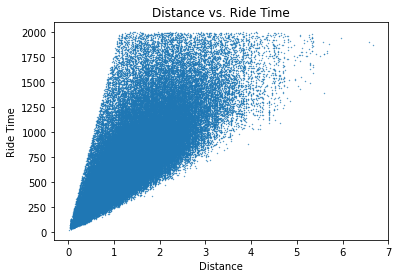

In [61]:
make_graph(sf_with_mean_locations.haversine_distance, sf_with_mean_locations.ride_time, "Distance", "Ride Time", "Distance vs. Ride Time")